In [ ]:
%pip install prophet
%pip install python-Levenshtein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 42.9 MB/s eta 0:00:00


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf # no need
from prophet import Prophet
from statsmodels.graphics.tsaplots import plot_acf # no need
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler # no need

USD/IDR Exchange Rate from Jan 2013 - May 2023

In [3]:
start_date = '2013-01-01'
# start_date_temp = '2008-07-01'

end_date = '2023-06-01'
# end_date_temp = '2009-07-01'

data_download = yf.download('USDIDR=X', start=start_date, end=end_date, progress=False)
data = data_download.drop(['Open',
                 'High',
                 'Low',
                 'Adj Close',
                 'Volume'],axis=1)

In [4]:
# extracting only the close values
values = pd.DataFrame(data['Close'])

# using shift function to shift the values.
dataframe = pd.concat([values.shift(i) for i in range(7, -2, -1)], axis=1)

# rename columns
dataframe.columns = [f't-{i}'for i in range(7, -2, -1)]
dataframe.columns = [i.replace('--', '+') for i in dataframe.columns]
dataframe.columns = [i.replace('t-0', 'Actual Close') for i in dataframe.columns]

# using shift function to shift the values.
dataframe = pd.concat([values.shift(i) for i in range(2, -2, -1)], axis=1)

# rename columns
dataframe.columns = ['t-2', 't-1', 'Actual Close', 'y']

# remove NaN
dataframe = dataframe[2:]
dataframe = dataframe[:2710]

dataframe

,t-2,t-1,Actual Close,y
Date,,,,
2013-01-03,9609.000000,9609.000000,9622.500000,9626.299805
2013-01-04,9609.000000,9622.500000,9626.299805,9770.000000
2013-01-07,9622.500000,9626.299805,9770.000000,9639.099609
2013-01-08,9626.299805,9770.000000,9639.099609,9641.200195
2013-01-09,9770.000000,9639.099609,9641.200195,9632.099609
...,...,...,...,...
2023-05-24,14918.000000,14886.000000,14895.000000,14945.900391
2023-05-25,14886.000000,14895.000000,14945.900391,14970.000000
2023-05-26,14895.000000,14945.900391,14970.000000,14948.000000


In [5]:
#Get econmic indicators differential
economic_indicators_differential = pd.read_excel('/content/Economic Indicators Differentials.xlsx', index_col=0,)

economic_indicators_differential

,Current Account Differential,Inflation Rate Differential,Interest Rate Differential,Trade Balance Differential,Foreign Exchange Reserve (USD)
Date,,,,,
2013-01-01,98899993993,0.05625,0.0410,44150000000,98100000000
2013-01-02,98899993993,0.05625,0.0410,44150000000,98100000000
2013-01-03,98899993993,0.05625,0.0410,44150000000,98100000000
2013-01-04,98899989874,0.05625,0.0410,44150000000,98100000000
2013-01-07,98899991360,0.05625,0.0410,44150000000,98100000000
...,...,...,...,...,...
2023-05-25,219300004181,0.00625,0.0051,67110000000,145200000000
2023-05-26,219300004181,0.00625,0.0051,67110000000,145200000000
2023-05-29,219300004181,0.00625,0.0051,67110000000,145200000000


<Axes: >

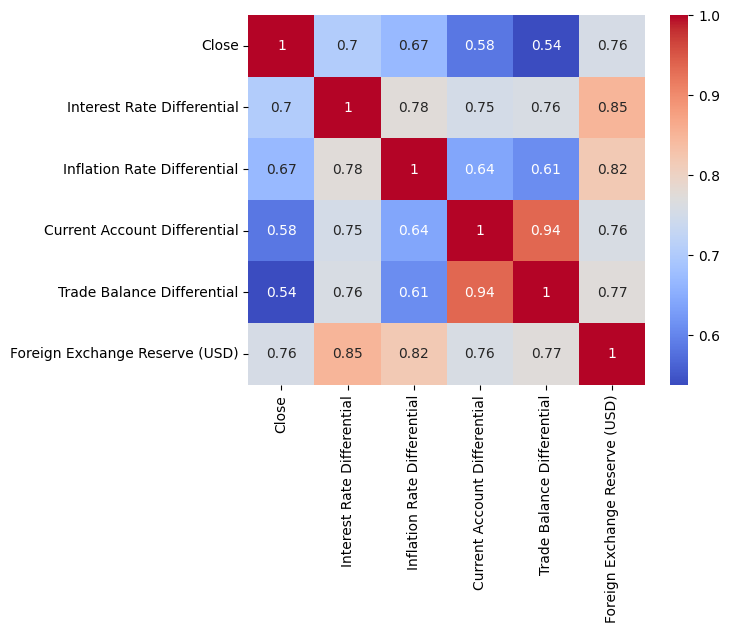

In [9]:
df = pd.DataFrame({
    'Close': dataframe['Actual Close'],
    'Interest Rate Differential':economic_indicators_differential['Interest Rate Differential'],
    'Inflation Rate Differential':economic_indicators_differential['Inflation Rate Differential'],
    'Current Account Differential':economic_indicators_differential['Current Account Differential'],
    'Trade Balance Differential':economic_indicators_differential['Trade Balance Differential'],
    'Foreign Exchange Reserve (USD)':economic_indicators_differential['Foreign Exchange Reserve (USD)']
})

sns.heatmap(df.corr().abs(), annot=True, cmap='coolwarm')

In [6]:
#merge the dataframe with economic indicators with concat
time_series = pd.merge(left=dataframe, right=economic_indicators_differential, left_on=dataframe.index, right_on=economic_indicators_differential.index, how='left')
time_series.columns = [i.replace('key_0', 'ds') for i in time_series.columns]

time_series

,ds,t-2,t-1,Actual Close,y,Current Account Differential,Inflation Rate Differential,Interest Rate Differential,Trade Balance Differential,Foreign Exchange Reserve (USD)
0,2013-01-03,9609.000000,9609.000000,9622.500000,9626.299805,98899993993,0.05625,0.0410,44150000000,98100000000
1,2013-01-04,9609.000000,9622.500000,9626.299805,9770.000000,98899989874,0.05625,0.0410,44150000000,98100000000
2,2013-01-07,9622.500000,9626.299805,9770.000000,9639.099609,98899991360,0.05625,0.0410,44150000000,98100000000
3,2013-01-08,9626.299805,9770.000000,9639.099609,9641.200195,98899991360,0.05625,0.0681,44150000000,98100000000
4,2013-01-09,9770.000000,9639.099609,9641.200195,9632.099609,98899991360,0.05625,0.0681,44150000000,98100000000
...,...,...,...,...,...,...,...,...,...,...
2705,2023-05-24,14918.000000,14886.000000,14895.000000,14945.900391,219300004181,0.00625,0.0051,67110000000,145200000000
2706,2023-05-25,14886.000000,14895.000000,14945.900391,14970.000000,219300004181,0.00625,0.0051,67110000000,145200000000
2707,2023-05-26,14895.000000,14945.900391,14970.000000,14948.000000,219300004181,0.00625,0.0051,67110000000,145200000000
2708,2023-05-29,14945.900391,14970.000000,14948.000000,14960.000000,219300004181,0.00625,0.0051,67110000000,145200000000


Split Data into 80/20

In [7]:
train = time_series.iloc[:len(time_series)-542]
test = time_series.iloc[len(time_series)-542:]

In [8]:
model = Prophet()
model.add_regressor('t-2',standardize=False)
model.add_regressor('t-1',standardize=False)
model.add_regressor('Actual Close',standardize=False)
model.add_regressor('Current Account Differential',standardize=False)
model.add_regressor('Inflation Rate Differential',standardize=False)
model.add_regressor('Interest Rate Differential',standardize=False)
model.add_regressor('Trade Balance Differential',standardize=False)
model.add_regressor('Foreign Exchange Reserve (USD)',standardize=False)
model.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9l4g1ml6/4n51_new.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9l4g1ml6/vsdhwe8j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86101', 'data', 'file=/tmp/tmp9l4g1ml6/4n51_new.json', 'init=/tmp/tmp9l4g1ml6/vsdhwe8j.json', 'output', 'file=/tmp/tmp9l4g1ml6/prophet_modelnqoonw2y/prophet_model-20230717085159.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:51:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:52:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
08:52:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during 

In [9]:
forecast1 = model.predict(train)
forecast1

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Actual Close,Actual Close_lower,Actual Close_upper,Current Account Differential,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-03,9626.293017,9384.577957,9810.263408,9626.293017,9626.293017,5859.188491,5859.188491,5859.188491,-29.941732,...,-8918.979780,-8918.979780,-8918.979780,-20.599301,-20.599301,-20.599301,0.0,0.0,0.0,9589.404703
1,2013-01-04,9626.533319,9344.290370,9763.627708,9626.533319,9626.533319,5861.502211,5861.502211,5861.502211,-29.941731,...,-8957.610477,-8957.610477,-8957.610477,-21.680435,-21.680435,-21.680435,0.0,0.0,0.0,9553.281716
2,2013-01-07,9627.254223,9512.270152,9934.102549,9627.254223,9627.254223,5949.001980,5949.001980,5949.001980,-29.941731,...,-8880.226311,-8880.226311,-8880.226311,-23.110784,-23.110784,-23.110784,0.0,0.0,0.0,9720.578137
3,2013-01-08,9627.494525,9431.894338,9848.631174,9627.494525,9627.494525,5869.296076,5869.296076,5869.296076,-29.941731,...,-8902.077927,-8902.077927,-8902.077927,-23.029970,-23.029970,-23.029970,0.0,0.0,0.0,9629.458575
4,2013-01-09,9627.734826,9441.186742,9863.948697,9627.734826,9627.734826,5870.575133,5870.575133,5870.575133,-29.941731,...,-8904.170269,-8904.170269,-8904.170269,-22.707626,-22.707626,-22.707626,0.0,0.0,0.0,9649.304837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2163,2021-04-26,10303.306816,14318.045391,14732.698515,10303.306816,10303.306816,8840.082983,8840.082983,8840.082983,-59.247699,...,-8880.226311,-8880.226311,-8880.226311,-8.789834,-8.789834,-8.789834,0.0,0.0,0.0,14528.691863
2164,2021-04-27,10303.397573,14271.646455,14678.003792,10303.397573,10303.397573,8804.522692,8804.522692,8804.522692,-59.247699,...,-8902.077927,-8902.077927,-8902.077927,-6.815254,-6.815254,-6.815254,0.0,0.0,0.0,14475.444082
2165,2021-04-28,10303.488330,14283.580635,14694.018642,10303.488330,10303.488330,8839.108973,8839.108973,8839.108973,-59.247699,...,-8904.170269,-8904.170269,-8904.170269,-4.744629,-4.744629,-4.744629,0.0,0.0,0.0,14487.045367
2166,2021-04-29,10303.579086,14260.619208,14682.334657,10303.579086,10303.579086,8840.691888,8840.691888,8840.691888,-59.247699,...,-8918.979780,-8918.979780,-8918.979780,-2.624792,-2.624792,-2.624792,0.0,0.0,0.0,14468.138025


In [10]:
forecast2 = model.predict(test)
forecast2

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Actual Close,Actual Close_lower,Actual Close_upper,Current Account Differential,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-05-03,10303.942113,14252.480768,14676.914660,10303.942113,10303.942113,8791.370582,8791.370582,8791.370582,-59.247699,...,-8880.226311,-8880.226311,-8880.226311,5.395557,5.395557,5.395557,0.0,0.0,0.0,14477.109556
1,2021-05-04,10304.032870,14203.991207,14630.835551,10304.032870,10304.032870,8767.683939,8767.683939,8767.683939,-59.247699,...,-8902.077927,-8902.077927,-8902.077927,7.059097,7.059097,7.059097,0.0,0.0,0.0,14416.567792
2,2021-05-05,10304.123627,14271.038639,14665.629381,10304.123627,10304.123627,8818.466855,8818.466855,8818.466855,-59.247699,...,-8904.170269,-8904.170269,-8904.170269,8.505284,8.505284,8.505284,0.0,0.0,0.0,14463.456967
3,2021-05-06,10304.214384,14211.830978,14598.551390,10304.214384,10304.214384,8767.927739,8767.927739,8767.927739,-59.247699,...,-8918.979780,-8918.979780,-8918.979780,9.701273,9.701273,9.701273,0.0,0.0,0.0,14397.631430
4,2021-05-07,10304.305140,14094.361810,14489.902695,10304.305140,10304.305140,8697.477310,8697.477310,8697.477310,-59.247699,...,-8957.610477,-8957.610477,-8957.610477,10.619738,10.619738,10.619738,0.0,0.0,0.0,14300.684573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537,2023-05-24,10372.100414,14495.755224,14949.577391,10270.510331,10476.684899,9069.640173,9069.640173,9069.640173,-66.392541,...,-8904.170269,-8904.170269,-8904.170269,-11.222014,-11.222014,-11.222014,0.0,0.0,0.0,14720.862351
538,2023-05-25,10372.191171,14494.089893,14959.806735,10270.339014,10476.994297,9100.633676,9100.633676,9100.633676,-66.392541,...,-8918.979780,-8918.979780,-8918.979780,-13.275458,-13.275458,-13.275458,0.0,0.0,0.0,14729.063820
539,2023-05-26,10372.281927,14492.001916,14932.586411,10270.177690,10477.303695,9115.308049,9115.308049,9115.308049,-66.392541,...,-8957.610477,-8957.610477,-8957.610477,-15.173062,-15.173062,-15.173062,0.0,0.0,0.0,14709.089446
540,2023-05-29,10372.554198,14554.070963,15031.738994,10270.203143,10477.794607,9101.912139,9101.912139,9101.912139,-66.392541,...,-8880.226311,-8880.226311,-8880.226311,-19.632505,-19.632505,-19.632505,0.0,0.0,0.0,14781.410570


In [11]:
# calculate RMSE for fbprophet
score = np.sqrt(mean_squared_error(test['y'], forecast2['yhat']))
print('Score: %.2f RMSE' % (score))

# # calculate MSE for fbprophet
score = mean_squared_error(test['y'], forecast2['yhat'])
print('Score: %.2f MSE' % (score))

# # calculate MAE for fbprophet
score = mean_absolute_error(test['y'], forecast2['yhat'])
print('Score: %.2f MAE' % (score))

# # calculate R2 for fbprophet
score = r2_score(test['y'], forecast2['yhat'])
print('Score: %.2f R2' % (score))

Score: 143.01 RMSE
Score: 20452.24 MSE
Score: 113.44 MAE
Score: 0.90 R2


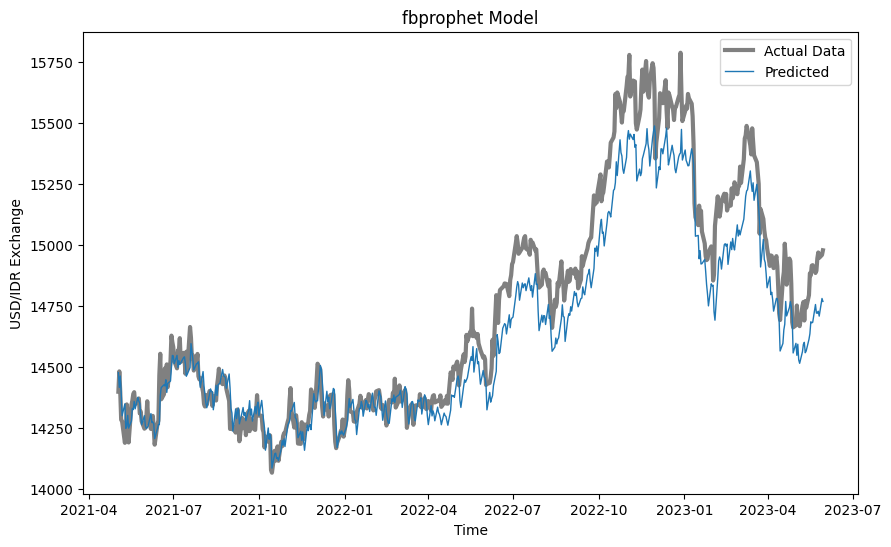

In [13]:
# create plot figure
plt.figure(figsize=(10,6))
plt.plot(test['ds'],test['y'],color='grey',label='Actual Data',linewidth='3')
# plt.plot(forecast1['ds'],forecast1['yhat'],color='red',label='training',linewidth='0.5')
plt.plot(forecast2['ds'],forecast2['yhat'],label='Predicted',linewidth='1')
plt.title('fbprophet Model')
plt.xlabel('Time')
plt.ylabel('USD/IDR Exchange')
plt.legend()
plt.show()

In [38]:
# Create a DataFrame to store predicted values
predicted_data = pd.DataFrame({'Date': time_series['ds'], 'Actual Close': time_series['Actual Close']})
# predicted_data
# Export predicted values to a CSV file
predicted_data.to_csv('Actual Close.csv', index=False)